In [1]:
# Cell 1: 환경 설정 및 Drive 마운트
!pip install torchaudio
from google.colab import drive
from pathlib import Path
import torch
import torchaudio

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET_ROOT = Path('/content/drive/MyDrive/Audio_2')
test_file = next(DATASET_ROOT.rglob("*.wav"), None) # 첫 번째 WAV 파일 로드

if test_file is None:
    raise FileNotFoundError("음성 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

# 데이터 로드
waveform, sample_rate = torchaudio.load(test_file)
print(f"Loaded: {test_file.name}, SR: {sample_rate} Hz")
print(f"Original Waveform shape: {waveform.shape}")

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Loaded: ED-EV-F-15-ko-221004-100000_1561_1_18-en.wav, SR: 16000 Hz
Original Waveform shape: torch.Size([1, 93610])


In [4]:
import torch.nn.functional as F
from pathlib import Path
import torchaudio.transforms as T
import torch
import torchaudio
import matplotlib.pyplot as plt

# --- 1. Wav2Vec2 모델 및 파이프라인 로드 ---
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
TARGET_SR = bundle.sample_rate

# --- 2. 디코딩 유틸리티 함수 정의 ---
def decode_text(emission, labels):
    # CTC 디코딩 (가장 확률 높은 인덱스 선택)
    emission = emission[0].cpu().argmax(dim=-1)
    # 인덱스를 문자열 레이블로 변환 (공백 토큰 ' | ' 제거 후 출력)
    return "".join([labels[i] for i in emission]).replace('|', ' ')

# Define file_list by listing all .wav files in the DATASET_ROOT
file_list = list(DATASET_ROOT.rglob("*.wav"))


# --- 3. 모든 파일에 대해 기본 ASR 실행 ---
results = {} # 결과를 저장할 딕셔너리
for i, file_path_str in enumerate(file_list):
    file_path = Path(file_path_str)
    print(f"\n--- [파일 {i+1}/{len(file_list)}] {file_path.name} ASR 실행 ---")

    try:
        # a. 파일 로드 및 SR 통일
        waveform_cpu, sample_rate = torchaudio.load(file_path)
        waveform = waveform_cpu.to(device)

        if sample_rate != TARGET_SR:
            resampler = T.Resample(sample_rate, TARGET_SR).to(device)
            waveform = resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = waveform[:1, :] # 모노 채널만 사용

        # b. 모델 추론 (Inference)
        with torch.no_grad():
            emission, _ = model(waveform)

        # c. 텍스트 디코딩
        transcript = decode_text(emission, labels)

        # 결과를 딕셔너리에 저장
        results[file_path.name] = {"waveform": waveform, "transcript": transcript}

        print(f"인식된 텍스트: {transcript}")

    except Exception as e:
        print(f"[오류] {file_path.name} 파일 처리 중 문제 발생: {e}")

print("\n기본 ASR 파이프라인 실행 완료.")


--- [파일 1/2] ED-EV-F-15-ko-221004-100000_1561_1_18-en.wav ASR 실행 ---


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

인식된 텍스트: ----------------------------------------------------------------D--O--NN---- W----OR-----R---Y---   --------------------------------L---E--T----S-   ----H-----O----P----R----E------  --G-----O---S------E----W-----E----R--    -------------------------------------------------------------------

--- [파일 2/2] NA-NA-F-13-ko-220812-100000_133_1_19-en.wav ASR 실행 ---
인식된 텍스트: -------------------------------------------------------------------------------C----OR----R--U-C--------T--------EER-----R-----ER---SS  ---F-R--OMM--  --FF---IF-------T--E----ENN----  TTOO   ---F----I-F------TT-----Y---  --------------------------------------

기본 ASR 파이프라인 실행 완료.


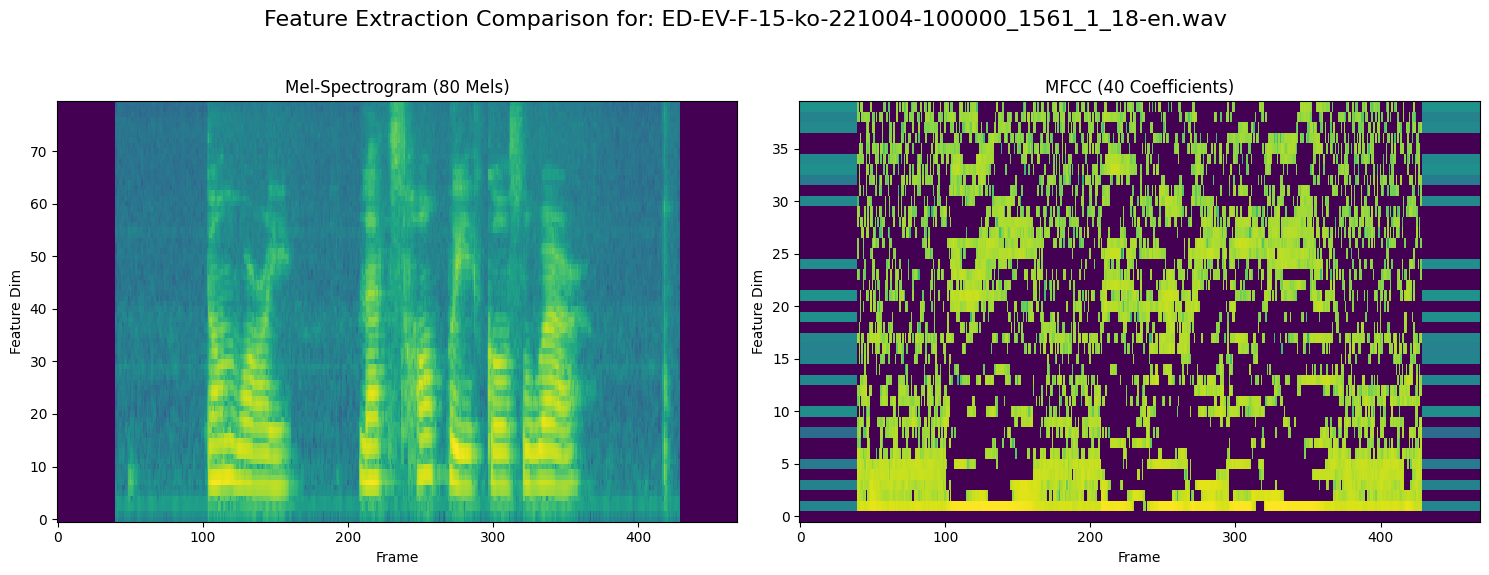

Mel-Spectrogram Shape: torch.Size([1, 80, 469])
MFCC Shape: torch.Size([1, 40, 469])

--- 정확도 향상 분석 아이디어 ---
Wav2Vec2 ASR 결과: ----------------------------------------------------------------D--O--NN---- W----OR-----R---Y---   --------------------------------L---E--T----S-   ----H-----O----P----R----E------  --G-----O---S------E----W-----E----R--    -------------------------------------------------------------------
MFCC나 Mel-Spectrogram 같은 다른 특징을 추출해보았습니다.
이 특징들을 직접 Wav2Vec2에 넣지는 않지만, 다른 ASR 모델(e.g., RNN/CNN 기반)에서는 이 특징들이 더 좋은 성능을 낼 수 있습니다.
정확도를 올리려면 디코딩 과정에 언어 모델을 결합하는 'Beam Search'를 구현하는 시도가 효과적일 것입니다.


In [5]:
# --- 1. 특징 추출 변환기 정의 ---
# Wav2Vec2가 요구하는 16kHz를 기준으로 설정
TARGET_SR = bundle.sample_rate # Cell 1에서 로드됨

# A. Mel-Spectrogram: 인간의 청각 특징 모방
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SR,
    n_fft=400,
    n_mels=80
).to(device)

# B. MFCC (Mel-Frequency Cepstral Coefficients): 전통적인 음성 인식 특징
mfcc_transform = T.MFCC(
    sample_rate=TARGET_SR,
    n_mfcc=40,
    melkwargs={"n_fft": 400, "n_mels": 40}
).to(device)

# --- 2. 특징 시각화 함수 정의 ---
def plot_features(feature, title, ax):
    # 특징 맵을 dB 스케일로 변환
    spec_db = T.AmplitudeToDB()(feature)
    ax.imshow(spec_db[0].cpu().numpy(), origin='lower', aspect='auto', interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Frame")
    ax.set_ylabel("Feature Dim")


# --- 3. 첫 번째 파일에 대해 특징 추출 및 시각화 ---
if results:
    first_file = next(iter(results))
    waveform_1 = results[first_file]["waveform"]

    # a. Mel-Spectrogram 추출
    mel_spectrogram = mel_spectrogram_transform(waveform_1)

    # b. MFCC 추출
    mfcc = mfcc_transform(waveform_1)

    # 시각화 비교
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f"Feature Extraction Comparison for: {first_file}", fontsize=16)

    plot_features(mel_spectrogram, "Mel-Spectrogram (80 Mels)", axes[0])
    plot_features(mfcc, "MFCC (40 Coefficients)", axes[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"Mel-Spectrogram Shape: {mel_spectrogram.shape}")
    print(f"MFCC Shape: {mfcc.shape}")

    # --- 정확도 향상 분석 ---
    print("\n--- 정확도 향상 분석 아이디어 ---")
    print(f"Wav2Vec2 ASR 결과: {results[first_file]['transcript']}")
    print("MFCC나 Mel-Spectrogram 같은 다른 특징을 추출해보았습니다.")
    print("이 특징들을 직접 Wav2Vec2에 넣지는 않지만, 다른 ASR 모델(e.g., RNN/CNN 기반)에서는 이 특징들이 더 좋은 성능을 낼 수 있습니다.")
    print("정확도를 올리려면 디코딩 과정에 언어 모델을 결합하는 'Beam Search'를 구현하는 시도가 효과적일 것입니다.")
else:
    print("이전 셀에서 인식 결과를 가져오지 못했습니다. Cell 1을 먼저 실행하세요.")